# Auto Encoder Outlier Detector (AEOD)

----

**Created by**:

- **Author**: Dr. Saad Laouadi
- **Date**: 14/08/2024

This notebook was created by dr. Saad Laouadi on August 14th, 2024 as part of a series on anomaly detection algorithms. The content is designed for researchers, data scientists, and practitioners interested in applying the Auto-Encoder algorithm to identify anomalies in diverse datasets.

**Copyright**

**© 2024 Dr. Saad Laouadi. All rights reserved.**

---

## Table of Contents

1. [Objective](#Objective)
2. [Prerequisites](#Prerequisites)
3. [Theoretical Background of SUOD](#theoretical-background-of-suod)
   - 3.1. [Ensemble Learning Theory](#ensemble-learning-theory)
   - 3.2. [Dimensionality Reduction](#dimensionality-reduction)
   - 3.3. [Approximation Theory](#approximation-theory)
4. [Mathematical Framework](#mathematical-framework)
   - 4.1. [Ensemble Outlier Score](#ensemble-outlier-score)
   - 4.2. [Random Projection](#random-projection)
   - 4.3. [Pseudo-supervised Approximation](#pseudo-supervised-approximation)
5. [Computational Complexity](#computational-complexity)
6. [Training SUOD with PYOD](#training-suod-with-pyod)
   - 6.1. [Installing the SUOD Module](#installing-the-suod-module)
   - 6.2. [Key Parameters of SUOD](#key-parameters-of-suod)
   - 6.3. [Methods in SUOD](#methods-in-suod)
     - 6.3.1. [fit()](#fit)
     - 6.3.2. [predict()](#predict)
     - 6.3.3. [decision_function()](#decision_function)
   - 6.4. [Training SUOD Workflow](#training-suod-workflow)
7. [Practical Example of SUOD System with Simulated Data](#practical-example-of-suod-system-with-simulated-data)
8. [Real-World Example](#real-world-example)
   - 8.1. [SUOD System Workflow](#suod-system-workflow)
      - 8.1.1. [Data Preprocessing](#data-preprocessing)
      - 8.1.2. [SUOD Application](#suod-application)
      - 8.1.3. [Performance Evaluation](#performance-evaluation)
      - 8.1.4. [Result Analysis and Interpretation](#result-analysis-and-interpretation)
      - 8.1.5. [Model Refinement (Optional)](#model-refinement-optional)
   - 8.2. [Configuring the SUOD System](#configuring-the-suod-system)
9. [Training SUOD as an Unsupervised Problem](#Training-SUOD-as-an-Unsupervised-Problem)

10. [Conclusion](#Conclusion)
11. [References](#References)

## Objective

The primary objective of this notebook is to provide a comprehensive exploration of the **Auto Encoder Outlier Detector (AEOD)** algorithm, encompassing its theoretical foundations, practical implementation, and performance evaluation. Specifically, this notebook aims to:

1. **Elucidate the Theoretical Framework**: Present a detailed explanation of the underlying principles of auto-encoders and their application to outlier detection, including the architecture, loss functions, and optimization techniques.

2. **Demonstrate Practical Implementation**: Guide readers through the step-by-step process of implementing AEOD using popular machine learning libraries, with a focus on code efficiency and best practices.

3. **Explore Hyperparameter Tuning**: Investigate the impact of various hyperparameters on AEOD's performance, providing insights into optimal configuration for different types of datasets.

4. **Analyze Performance**: Evaluate AEOD's effectiveness in detecting outliers using both synthetic and real-world datasets, employing appropriate evaluation metrics and visualization techniques.

5. **Compare with Other Techniques**: Benchmark AEOD against traditional outlier detection methods to highlight its strengths and potential limitations.

6. **Discuss Real-World Applications**: Present case studies demonstrating AEOD's applicability in various domains, such as fraud detection, anomaly detection in time series data, or identifying rare events in high-dimensional spaces.

7. **Address Challenges and Limitations**: Discuss potential challenges in implementing AEOD, including computational complexity, sensitivity to noise, and interpretability of results.

By the end of this notebook, readers will have gained a thorough understanding of the Auto Encoder Outlier Detector, equipped with the knowledge and practical skills to apply this algorithm effectively in their own anomaly detection tasks across diverse datasets and domains.

### Prerequisites

This notebook assumes a foundational understanding of Python tools for data manipulation and processing. The following prerequisites will help you get the most out of this material:

1. **Data Manipulation**:
   - Familiarity with reading and writing data using libraries such as **Pandas** and **NumPy**.

2. **Machine Learning Workflow**:
   - Prior experience with the **Scikit-learn** library, including:
     - Preprocessing techniques like scaling and normalization.
     - Splitting data into training and test sets using tools like `train_test_split`.

3. **Data Visualization**:
   - Proficiency in using plotting libraries such as **Matplotlib** and **Seaborn** for visualizing data and model results.

4. **Deep Learning Frameworks**:
   - Familiarity with autoencoders and experience using deep learning frameworks like **TensorFlow** or **PyTorch** for model development and training.

In [1]:
# ============================================================================================# 
#                                 Environment Setup
#  Here we import all the necessary modules and tools we will use through this notebook
# ============================================================================================# 
import os
import sys
import time
from collections import Counter

import numpy as np 
import pandas as pd
from scipy.io import arff

from pyod.models.abod import ABOD
from pyod.models.ecod import ECOD
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from pyod.models.auto_encoder import AutoEncoder

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns

# The utils module is not an installable package, it is the same directory as this notebook
from utils import generate_data, visualize_data, apply_abod, apply_abod_advanced, precision_at_rank_n
from utils import grid_search_abod, hyperopt_objective, plot_outliers_vs_inliers
from utils import preprocess_pipeline

from suod_utils import generate_sample_data, evaluate_model, visualize_results

from pyod.models.suod import SUOD
from pyod.models.lof import LOF
from pyod.models.iforest import IForest
from pyod.models.copod import COPOD
from pyod.models.knn import KNN
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.utils.utility import standardizer
from pyod.utils.data import generate_data, get_outliers_inliers, evaluate_print
from pyod.utils.example import visualize

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll.base import scope

def print_banner(sep, nchar, title):
    print(sep * nchar)
    print(title.center(nchar))
    print(sep * nchar)

# Configuration 
DATA_PATH = "../../datasets/HeartDisease/HeartDisease_withoutdupl_norm_44.arff"

# Theoretical Background of AEOD

## 1. Introduction

Auto Encoder Outlier Detector (AEOD) is an unsupervised machine learning algorithm designed for detecting anomalies or outliers in complex datasets. It leverages the power of auto-encoders, a type of neural network architecture, to identify data points that significantly deviate from the norm.

Auto-encoders are neural networks trained to reconstruct their input data, typically through a bottleneck layer that forces the network to learn a compressed representation of the data. In the context of anomaly detection, auto-encoders are utilized based on the principle that they will struggle to accurately reconstruct outliers, which by definition do not conform to the patterns present in the majority of the data.


The fundamental premise underlying AEOD's effectiveness is rooted in the auto-encoder's behavior when confronted with outliers. While the network is adept at reconstructing data points that conform to the patterns observed in the majority of the training set, it struggles to accurately reproduce outliers. This discrepancy in reconstruction fidelity forms the basis for anomaly identification.

By exploiting this principle, AEOD offers a nuanced and powerful tool for detecting anomalies in scenarios where traditional statistical methods may falter. Its ability to capture complex, non-linear relationships in data makes it particularly suited for high-dimensional problems across various domains, from financial fraud detection to industrial equipment monitoring.


## 2. Core Components

### 2.1 Auto-Encoder Architecture

The AEOD algorithm employs an auto-encoder neural network consisting of:
- An encoder network that compresses the input data into a lower-dimensional representation
- A decoder network that attempts to reconstruct the original input from this compressed representation
- A bottleneck layer between the encoder and decoder, representing the latent space

### 2.2 Dimensionality Reduction

The encoder portion of the auto-encoder effectively performs non-linear dimensionality reduction, mapping the input data to a lower-dimensional latent space. This process helps in capturing the most salient features of the data while filtering out noise.

### 2.3 Reconstruction Error as Anomaly Score

The key idea in AEOD is to use the reconstruction error as an anomaly score. Normal data points, which the auto-encoder has learned to reconstruct well, will have low reconstruction errors. Conversely, anomalies or outliers, being different from the majority of the training data, will typically result in higher reconstruction errors.

### 2.4 Latent Space Representation

The compressed representation in the bottleneck layer, known as the latent space, captures the essential features of the input data. This latent representation can be useful for visualization and further analysis of the data structure.

## 3. Theoretical Underpinnings

### 3.1 Unsupervised Learning Theory

AEOD operates within the framework of unsupervised learning, where the algorithm learns patterns and structures from data without explicit labels. The theory of unsupervised learning, particularly manifold learning and representation learning, forms the basis for understanding how AEOD can identify anomalies without prior knowledge of what constitutes an anomaly.

### 3.2 Manifold Learning

The concept of manifold learning is crucial to AEOD. It assumes that high-dimensional data often lies on or near a lower-dimensional manifold. The auto-encoder learns to approximate this manifold, allowing it to effectively capture the intrinsic structure of the data.

### 3.3 Information Theory

Information theory provides insights into the compression achieved by the auto-encoder. The bottleneck layer can be viewed as a constrained information channel, forcing the network to learn an efficient coding of the input data. Anomalies, by their nature, require more information to encode and thus are less efficiently compressed and reconstructed.

## 4. Mathematical Framework

### 4.1 Auto-Encoder Model

Let $x$ be the input data, $f(x)$ be the encoder function, and $g(f(x))$ be the decoder function. The auto-encoder model can be expressed as:

$$\hat{x} = g(f(x))$$

where $\hat{x}$ is the reconstructed data.

### 4.2 Loss Function

The loss function L for training the auto-encoder is typically the mean squared error between the input and the reconstruction:

$$L = \|x - \hat{x}\|^2 = \|x - g(f(x))\|^2$$

### 4.3 Anomaly Score Calculation

The anomaly score S for a data point x is calculated as the reconstruction error:

$$S(x) = \|x - g(f(x))\|^2$$

A threshold $\tau$ is often used to classify points as anomalies:

If $S(x) > \tau$, $x$ is classified as an anomaly.

## 5. Computational Complexity

The computational complexity of AEOD can be divided into two phases:

1. Training: $O(N * E * M)$, where $N$ is the number of training samples, $E$ is the number of epochs, and $M$ is the model complexity (number of parameters).

2. Inference: $O(P)$, where $P$ is the number of parameters in the model, as each data point needs to be passed through the encoder and decoder once.

The exact complexity can vary based on the specific architecture and optimization techniques used. While training can be computationally intensive, especially for large datasets, inference is typically fast, making AEOD suitable for real-time anomaly detection in many applications.

## Training SUOD with PYOD

## Using AutoEncoder for Outlier Detection Using PyOD Framework

The `AutoEncoder` class from the `pyod.models.auto_encoder` module is designed for unsupervised outlier detection. AutoEncoders are a type of neural network that learn data representations by compressing and then reconstructing the input data. Outliers are identified by their higher reconstruction errors compared to normal data points.

### Key Parameters of AutoEncoder

- **contamination**: The proportion of outliers in the dataset.
  - Type: `float` (default=0.1)
  - Range: `(0, 0.5)`
  - Used to define the threshold on the decision function.

- **preprocessing**: Whether to apply preprocessing procedures before training the model.
  - Type: `bool` (default=True)

- **lr**: The initial learning rate for the optimizer.
  - Type: `float` (default=0.001)

- **epoch_num**: The number of epochs for training the model.
  - Type: `int` (default=10)

- **batch_size**: The batch size used during training.
  - Type: `int` (default=32)

- **optimizer_name**: The optimizer used to train the model.
  - Type: `str` (default='adam')

- **device**: The device used to train the model.
  - Type: `str` (default=None)
  - Example: Use `'mps'` to utilize Apple’s Metal Performance Shaders.

- **hidden_neuron_list**: Defines the number of neurons in each hidden layer.
  - Type: `list` (default=[64, 32])
  - Example: `[64, 32]` would create a network with layers [input_size, 64, 32, 32, 64, input_size].

- **hidden_activation_name**: The activation function used in hidden layers.
  - Type: `str` (default='relu')

- **batch_norm**: Whether to apply batch normalization after each layer.
  - Type: `bool` (default=True)

- **dropout_rate**: The dropout rate used in the model.
  - Type: `float` (default=0.2)
 

### Methods in AutoEncoder

- **fit()**: Trains the AutoEncoder on the provided data.
  - **Parameters**:
    - `X`: The input data to train on (ndarray of shape `(n_samples, n_features)`).
  - **Returns**:
    - `self`: The fitted AutoEncoder instance.
  - **Example**:
    ```python
    ae.fit(X_train)
    ```

- **predict()**: Predicts whether each sample is an outlier or not.
  - **Parameters**:
    - `X`: The input data to predict (ndarray of shape `(n_samples, n_features)`).
    - `return_confidence`: If `True`, also returns the confidence of the prediction.
  - **Returns**:
    - `outlier_labels`: Binary labels for each sample (0 for inliers, 1 for outliers).
    - `confidence` (optional): Confidence of the prediction (only returned if `return_confidence=True`).
  - **Example**:
    ```python
    y_pred = ae.predict(X_test)
    ```

- **decision_function()**: Computes the anomaly scores for the input data.
  - **Parameters**:
    - `X`: The input data to score (ndarray of shape `(n_samples, n_features)`).
  - **Returns**:
    - `anomaly_scores`: The anomaly scores for each sample (ndarray of shape `(n_samples,)`). Higher scores indicate a higher likelihood of being an outlier.
  - **Example**:
    ```python
    outlier_scores = ae.decision_function(X_test)
    ```


### Training Workflow for AutoEncoder

Here are the steps to train an AutoEncoder model:

1. **Import the AutoEncoder Class**: Start by importing the `AutoEncoder` class from `pyod.models.auto_encoder`.
    ```python
    from pyod.models.auto_encoder import AutoEncoder
    ```

2. **Initialize the AutoEncoder**: Create an instance of the AutoEncoder class with the desired parameters.
    ```python
    ae = AutoEncoder(contamination=0.1, hidden_neuron_list=[64, 32], batch_norm=True, dropout_rate=0.2, epoch_num=10)
    ```

3. **Train the Model**: Fit the model to the training data.
    ```python
    ae.fit(X_train)
    ```

4. **Make Predictions**: Use the `predict` method to classify data as inliers or outliers.
    ```python
    y_pred = ae.predict(X_test)
    ```

5. **Get Outlier Scores**: Retrieve the anomaly scores using the `decision_function`.
    ```python
    outlier_scores = ae.decision_function(X_test)
    ```

The AutoEncoder provides a flexible framework for detecting outliers using neural networks, making it suitable for datasets with complex structures that may not be well-served by traditional outlier detection algorithms.

> **Note**: For more detailed information, you can refer to the [pyod documentation](https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.auto_encoder).

## Practical Example of AEOD System with Simulated Data

In this section, we demonstrate the application of the AutoEncoder for Outlier Detection (AEOD) system using simulated data. We will walk through the process of:
1. Generating sample datasets
2. Initializing the AutoEncoder model for outlier detection
3. Training the AutoEncoder to learn data representations and detect outliers based on reconstruction errors
4. Evaluating the system's performance in identifying anomalies
5. Visualizing the results to gain insights into the detected outliers

This example will provide a hands-on understanding of how AEOD can be effectively utilized in practice.


### Installing `pytorch`

Note that you need to install `pytorch` in order to train AEOD since the backend of pyod framework for this algorithm is the `pytorch` framework. 

To install pytorch in your active environment: 


```sh
conda install pytorch torchvision -c pytorch
```

Or you can use pip

```sh
pip3 install torch torchvision
```

In [2]:
# test pytorch
import torch
x = torch.rand(5, 3)
print(x)

tensor([[0.6839, 0.4661, 0.5789],
        [0.2732, 0.6342, 0.2584],
        [0.9356, 0.2524, 0.7778],
        [0.2178, 0.1618, 0.1932],
        [0.9394, 0.5511, 0.6227]])


Training: 100%|██████████| 20/20 [00:01<00:00, 16.58it/s]


y_train has multiple classes: {np.float64(0.0), np.float64(1.0)}
y_test has multiple classes: {np.float64(0.0), np.float64(1.0)}

On Training Data:
AutoEncoder ROC:0.9818, precision @ rank n:0.9111

On Test Data:
AutoEncoder ROC:1.0, precision @ rank n:1.0


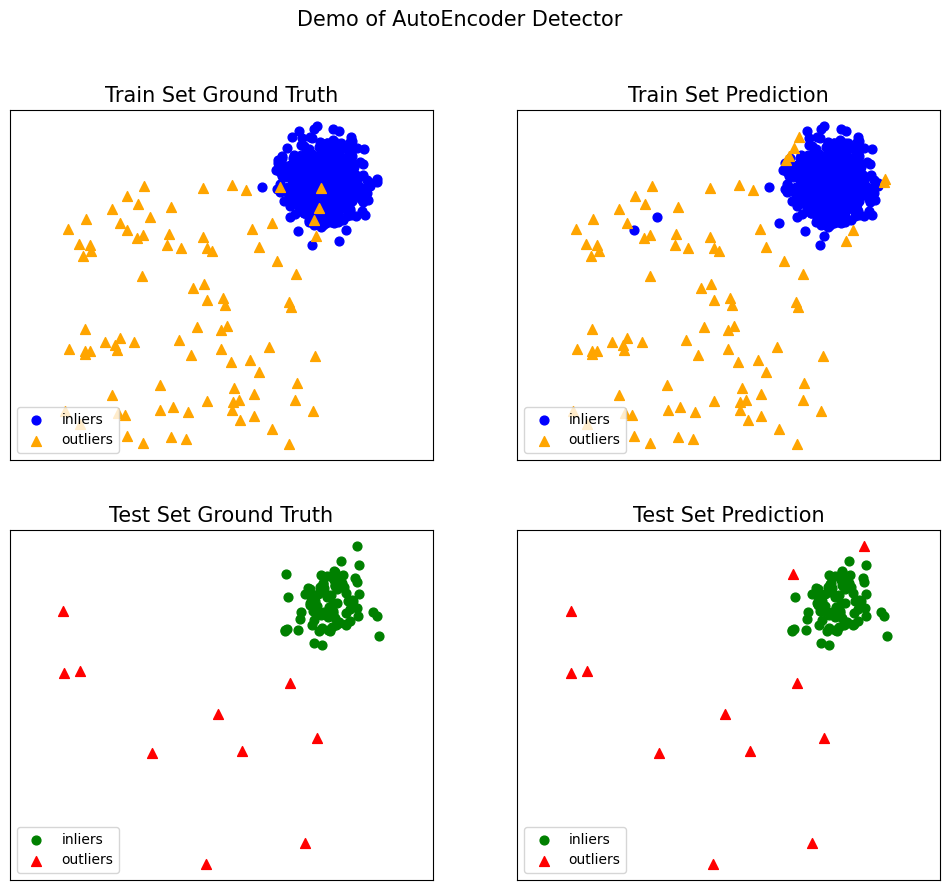

Process took 2.0902318954467773 seconds.


In [3]:
# Configuration
PRINT_MODEL_INFO = False                        # Set this to True to print the AutoEncoder model summary

start = time.time()
if __name__ == "__main__":
    contamination = 0.1                          # Percentage of outliers
    n_train = 900                                # Number of training points
    n_test = 100                                 # Number of testing points

    # Generate synthetic data
    X_train, X_test, y_train, y_test = generate_sample_data(
        n_train=n_train, n_test=n_test, n_features=2, contamination=contamination, random_state=42
    )

    # Initialize the AutoEncoder
    ae = AutoEncoder(
        contamination=contamination,
        hidden_neuron_list=[64, 32],
        hidden_activation_name='relu',
        batch_norm=True,
        dropout_rate=0.2,
        epoch_num=20,
        lr=0.001,
        batch_size=32,
        verbose=1,
    )

    # Train the AutoEncoder
    ae.fit(X_train)
    
    if PRINT_MODEL_INFO:
        print(ae.model)                                               # Print the AutoEncoder model summary
         
    # Get predictions
    y_train_pred = ae.predict(X_train)
    y_test_pred = ae.predict(X_test)
    
    # Get outlier scores
    y_train_scores = ae.decision_function(X_train)
    y_test_scores = ae.decision_function(X_test)

    # Evaluate the model
    evaluate_model('AutoEncoder', y_train, y_train_scores, y_test, y_test_scores)

    # Visualize the results
    visualize_results('AutoEncoder', X_train, y_train, X_test, y_test, y_train_pred, y_test_pred)

end = time.time()

print(f"Process took {end - start} seconds.")

---

## Real-World Example

We will use the heart disease dataset, the same dataset used in the previous algorithm examples. For more details on the dataset, you can refer to the [ABOD algorithm notebook](03-abod-algorithm.ipynb) or visit [this link](https://www.dbs.ifi.lmu.de/research/outlier-evaluation/DAMI/semantic/HeartDisease/HeartDisease_44.html).

### AutoEncoder Outlier Detection (AEOD) Workflow

To effectively leverage the AutoEncoder for outlier detection, follow these comprehensive steps:

1. **Data Preprocessing**:
   - **Handle Missing Data**: Impute or remove missing values to ensure the dataset's integrity.
   - **Eliminate Duplicates**: Remove duplicate entries to prevent bias in the outlier detection process.
   - **Encode Categorical Features**: Convert categorical variables into numerical format using techniques such as one-hot encoding or label encoding.
   - **Scale Features**: Normalize or standardize features to ensure a uniform scale across all input variables, which is crucial for many machine learning algorithms.
   - **Dimensionality Reduction** (Optional): Use techniques like PCA to reduce dimensionality, particularly when dealing with high-dimensional data.

2. **Applying the AutoEncoder**:
   - **Initialize the AutoEncoder**: Set up the AutoEncoder, specifying parameters such as hidden layers, learning rate, batch size, and epochs.
   - **Train the Model**: Fit the AutoEncoder to the preprocessed data. The model will learn to reconstruct the input data, and outliers will be identified based on reconstruction errors.
   - **Prediction**: Use the trained AutoEncoder to predict outliers in the dataset by calculating the reconstruction errors.

3. **Performance Evaluation**:
   - **Compute Metrics**: Evaluate the performance of the AutoEncoder using metrics such as:
     - Precision
     - ROC AUC (Area Under the Receiver Operating Characteristic Curve)
     - Average Precision
   - **Cross-Validation**: Implement k-fold cross-validation to ensure robust performance assessment.

4. **Result Analysis and Interpretation**:
   - **Visualize Outliers**: Generate scatter plots or other visualizations to represent detected outliers visually.
   - **Analyze Outlier Characteristics**: Identify common features or patterns among the detected outliers.
   - **Domain-Specific Interpretation**: Contextualize the detected outliers within the specific domain of the dataset.
   - **Comparative Analysis**: Compare the AutoEncoder's results with traditional single-algorithm approaches if applicable.

5. **Model Refinement** (Optional):
   - **Hyperparameter Tuning**: Adjust the AutoEncoder's parameters based on the initial results to improve performance.
   - **Model Architecture Adjustment**: Modify the structure of the AutoEncoder, such as the number of hidden layers or neurons, to enhance its ability to detect outliers.

> **Note**:  
> To reproduce the results in the following example, ensure you have downloaded the required dataset and saved it in an accessible directory. Additionally, verify that all necessary libraries and dependencies are installed in your environment.

### Configuring the AutoEncoder

In this example, I will configure the AutoEncoder with the following parameters to detect outliers:

- **Hidden Layers**: 
  - First hidden layer: 64 neurons
  - Second hidden layer: 32 neurons
  - The architecture mirrors itself with 32 neurons and then 64 neurons in the decoding phase.
- **Activation Function**: 
  - `ReLU` for hidden layers
- **Batch Normalization**: 
  - Applied to stabilize the learning process.
- **Dropout Rate**: 
  - Set to 0.2 to prevent overfitting.
- **Learning Rate**: 
  - 0.001
- **Epochs**: 
  - 20
- **Batch Size**: 
  - 32

In [7]:
PRINT_MODEL_INFO = False 

# Function to load the dataset
def load_arff_data(filepath):
    """
    Load an ARFF file and return it as a pandas DataFrame.

    Parameters
    ----------
    filepath : str
        Path to the ARFF file.

    Returns
    -------
    data : DataFrame
        The loaded dataset.
    """
    data, meta = arff.loadarff(filepath)
    df = pd.DataFrame(data)
    
    # Convert byte strings to normal strings for categorical variables
    for column in df.select_dtypes([object]).columns:
        df[column] = df[column].str.decode('utf-8')
    
    return df

# Preprocess the dataset
def preprocess_heart_disease_data(df, target_name, scale=False):
    """
    Preprocess the Heart Disease dataset.

    Parameters
    ----------
    df : DataFrame
        The loaded dataset.
    target_name: str
        The target column name.

    Returns
    -------
    X : ndarray
        Feature matrix.
    y : ndarray
        Target vector (outlier labels).
    """
    X = df.drop(columns=[target_name])                                 
    y = df[target_name].apply(lambda x: 1 if x == 'yes' else 0).values

    if scale:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
    else:
        X_scaled = X
    
    return X_scaled, y

def stratify_split_data(X, y, test_size=0.1, random_state=42):
    """
    Split the data into training and testing sets with stratification.

    Parameters
    ----------
    X : ndarray
        Feature matrix.
    y : ndarray
        Target vector.
    test_size : float, optional
        Proportion of the dataset to include in the test split (default is 0.1).
    random_state : int, optional
        Seed for random number generation (default is 42).

    Returns
    -------
    X_train : ndarray
        Training feature matrix.
    X_test : ndarray
        Testing feature matrix.
    y_train : ndarray
        Training target vector.
    y_test : ndarray
        Testing target vector.
    """
    # Ensure that the test set has a similar distribution of classes as the full dataset
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y, 
                                                        test_size=test_size,
                                                        random_state=random_state,
                                                        stratify=y)
    
    # Check class distribution
    print(f"Training set class distribution: {Counter(y_train)}")
    print(f"Test set class distribution: {Counter(y_test)}")
    
    return X_train, X_test, y_train, y_test

# Example of using the above functions with an AutoEncoder
if __name__ == "__main__":
    # Load the dataset
    DATA_PATH = "../../datasets/HeartDisease/HeartDisease_withoutdupl_norm_44.arff"
    df = load_arff_data(DATA_PATH)

    # Preprocess the dataset
    X, y = preprocess_heart_disease_data(df, target_name='outlier', scale=True)

    # Optionally split the dataset if needed (although for unsupervised learning, this may not be required)
    X_train, X_test, y_train, y_test = stratify_split_data(X, y, test_size=0.1, random_state=42)

    # Initialize the AutoEncoder detector
    ae = AutoEncoder(
        contamination=0.4444,                
        hidden_neuron_list=[128, 64, 32],    
        lr=0.001,                            
        epoch_num=50,                       
        batch_size=16,                       
        dropout_rate=0.1,                    
        verbose=1, 
        compile_mode=True
    )

    
    # Train the AutoEncoder model
    ae.fit(X_train)

    if PRINT_MODEL_INFO:
        print(ae.model)                                               # Print the AutoEncoder model summary

    # Get predictions
    y_train_pred = ae.predict(X_train)
    y_test_pred = ae.predict(X_test)
    
    # Get outlier scores
    y_train_scores = ae.decision_function(X_train)
    y_test_scores = ae.decision_function(X_test)

    # Evaluate the model
    evaluate_model('AutoEncoder', y_train_pred, y_train_scores, y_test_pred, y_test_scores)

    # Print the indices of the detected outliers
    outlier_indices = np.where(y_test_pred == 1)[0]
    print("Indices of the outliers:")
    print(outlier_indices)

    # Slice the data to have only the outliers
    outliers_only = X_test[outlier_indices, :]
    print(f"Number of detected outliers: {outliers_only.shape[0]}")

Training set class distribution: Counter({np.int64(0): 135, np.int64(1): 108})
Test set class distribution: Counter({np.int64(0): 15, np.int64(1): 12})


Training: 100%|██████████| 50/50 [00:02<00:00, 22.15it/s]

y_train has multiple classes: {np.int64(0), np.int64(1)}
y_test has multiple classes: {np.int64(0), np.int64(1)}

On Training Data:
AutoEncoder ROC:1.0, precision @ rank n:1.0

On Test Data:
AutoEncoder ROC:1.0, precision @ rank n:1.0
Indices of the outliers:
[ 0  2  3  4  7  8  9 10 11 12 13 15 17 18 19 20 22 24 25 26]
Number of detected outliers: 20


## Training AutoEncoder as an Unsupervised Problem

In this section, we’ll demonstrate how to train an AutoEncoder model for unsupervised outlier detection. AutoEncoders are particularly useful in unsupervised learning scenarios where the goal is to identify anomalies or outliers in the dataset without any labeled data. The model learns to compress and reconstruct the input data, and anomalies are identified based on their reconstruction error.

### Workflow Overview

1. **Data Preparation**:
    - We begin by loading and preprocessing the dataset. Since the task is unsupervised, we don’t require labels for the training data.
    - The entire dataset will be used to train the AutoEncoder, which will learn the underlying patterns of the data.

2. **Model Initialization**:
    - We initialize the AutoEncoder model with specified parameters such as the number of hidden layers, neurons per layer, learning rate, and dropout rate.
    - These parameters can be adjusted to increase the model's capacity and improve its ability to detect outliers.

3. **Training the AutoEncoder Model**:
    - The AutoEncoder is trained on the entire dataset. During training, the model learns to encode and decode the input data, with the objective of minimizing the reconstruction error.
    - Instances that cannot be reconstructed well by the model are flagged as potential outliers.

4. **Outlier Detection**:
    - After training, the model predicts which instances in the dataset are outliers based on their reconstruction errors.
    - The predicted outliers can then be further analyzed to understand why they were flagged by the model.

5. **Results Analysis**:
    - We’ll review the detected outliers by analyzing their reconstruction errors.
    - Visualization techniques will be used to illustrate the differences between inliers and outliers, providing insights into the model’s performance.

(270, 14)
(270,)
outlier
no     150
yes    120
Name: count, dtype: int64
120


Training: 100%|██████████| 100/100 [00:01<00:00, 58.43it/s]


************************************************************************
                        Training and Prediction                         
************************************************************************
************************************************************************
                         Displaying Information                         
************************************************************************
Outliers detected: 120 out of 270
Indices of the outliers:
[  0   1   2   4  10  11  13  15  17  18  19  22  24  25  28  31  33  35
  36  37  40  43  44  45  46  47  48  49  51  53  56  57  58  59  60  66
  71  72  75  82  85  86  87  89  96  98 101 103 108 109 110 117 118 119
 120 124 129 130 134 135 139 143 144 145 148 153 159 160 161 167 169 171
 174 175 177 178 180 181 183 184 185 187 191 192 193 198 199 203 205 207
 208 209 211 214 215 217 222 223 224 225 226 227 228 229 230 234 235 237
 240 244 250 253 254 255 256 259 262 264 265 269]
120
***********

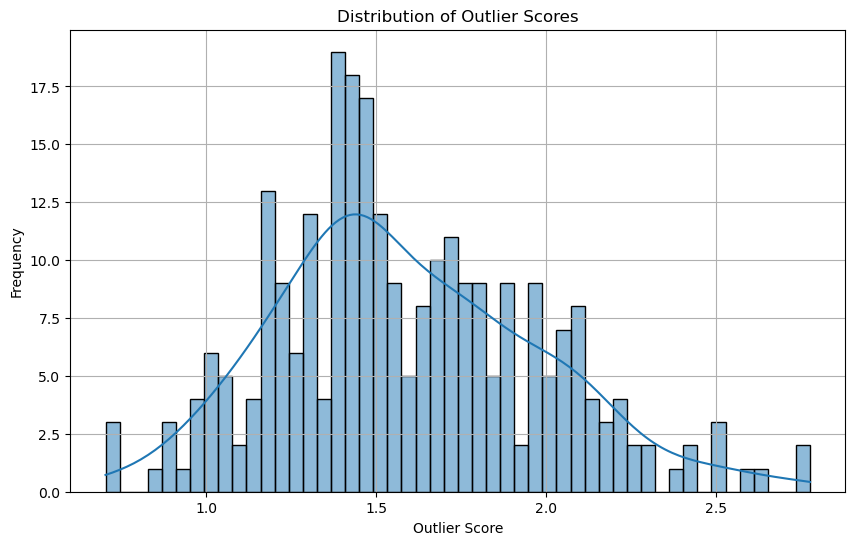

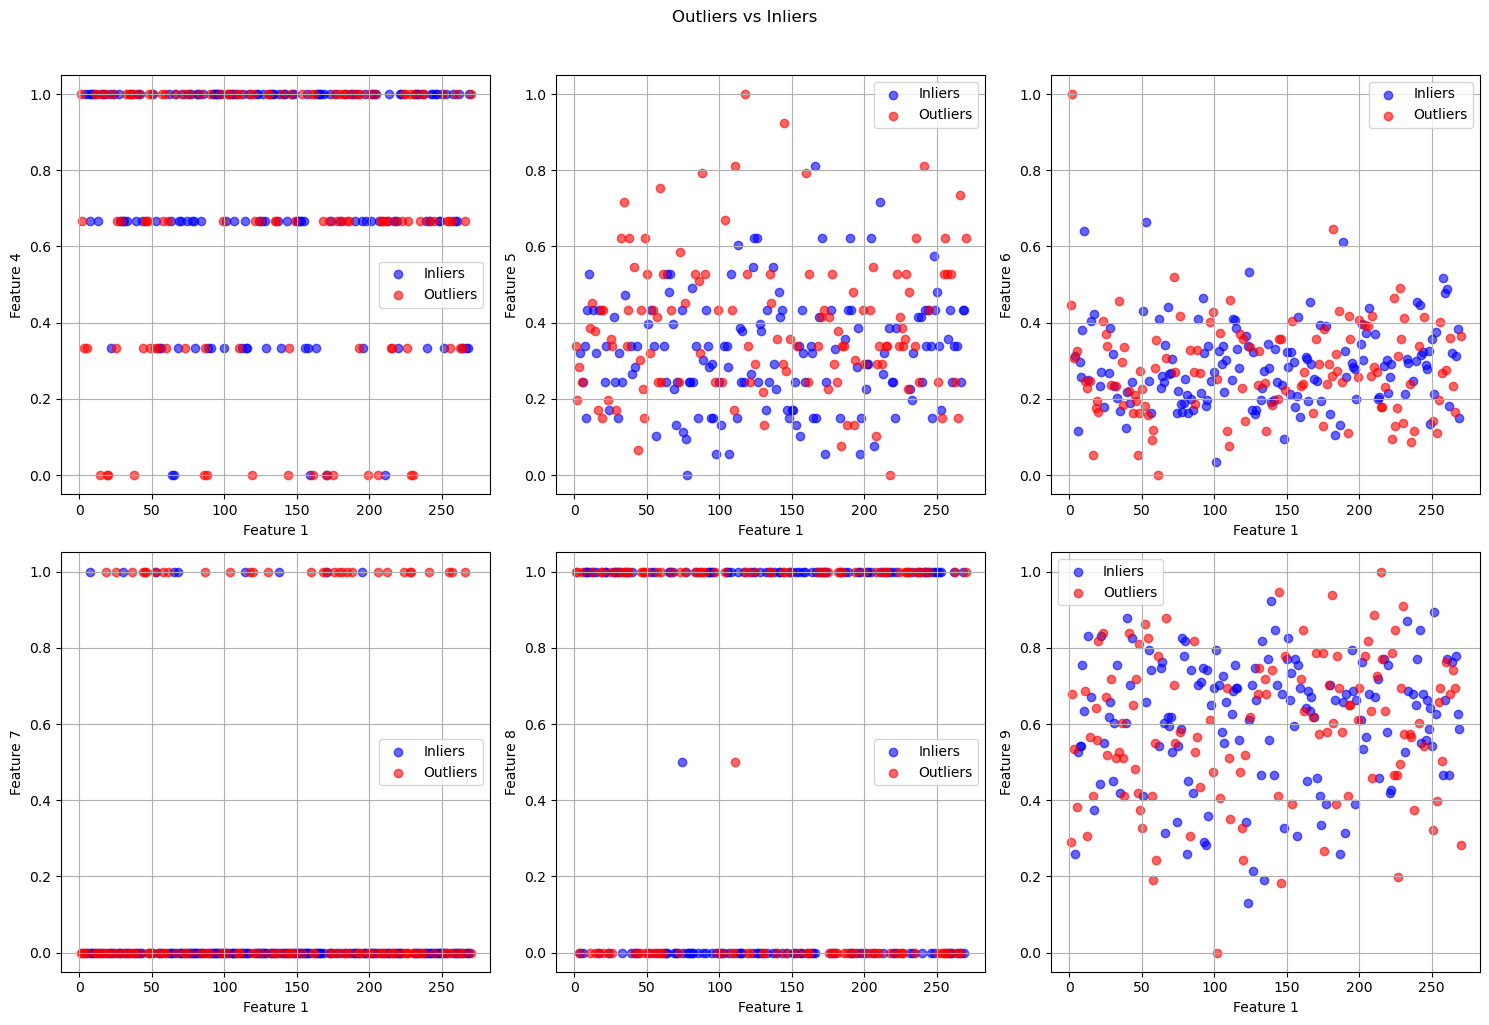

In [8]:
# Load and preprocess the dataset
df = load_arff_data(DATA_PATH)
X, y = preprocess_heart_disease_data(df, 'outlier')
print(X.shape)
print(y.shape)
print(df['outlier'].value_counts())
print(sum(y == 1))

# Initialize the AutoEncoder model
ae = AutoEncoder(
    contamination=0.4444, 
    hidden_neuron_list=[64, 32], 
    hidden_activation_name='relu', 
    batch_size=32, 
    epoch_num=100, 
    lr=0.001, 
    verbose=1
)

# Train the AutoEncoder model
ae.fit(X)

print_banner("*", 72, "Training and Prediction")

# Get predictions
y_pred = ae.labels_  # binary labels (0: inliers, 1: outliers)
outlier_scores = ae.decision_scores_  # raw outlier scores

print_banner("*", 72, "Displaying Information")
# You can now analyze the results
print(f"Outliers detected: {sum(y_pred)} out of {len(y_pred)}")

# Getting the outlier indexes
outlier_indices = np.where(y_pred == 1)[0]

# Print the indexes of the outliers
print("Indices of the outliers:")
print(outlier_indices)

# Slice the data to have only the outliers
outliers_only = X.iloc[outlier_indices, :]
print(outliers_only.shape[0])

print_banner("*", 72, "Plotting")

# Plot the distribution of outlier scores
plt.figure(figsize=(10, 6))
sns.histplot(outlier_scores, bins=50, kde=True)
plt.title("Distribution of Outlier Scores")
plt.xlabel("Outlier Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Plot outlier scores against selected features
plot_outliers_vs_inliers(X, y_pred=y_pred, plot_features=[3, *range(4, 9)])